<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/RCPSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Proposto por Peter Nightingale, Emir Demirović, o problema de escalonamento de projetos com restrição de recursos é um problema clássico bem conhecido na pesquisa operacional. Um conjunto de atividades deve ser agendado. Cada atividade tem uma duração e não pode ser interrompida. Há um conjunto de relações de precedência entre pares de atividades que estabelecem que a segunda atividade deve começar após o término da primeira. 

O conjunto de relações de precedência geralmente pode ser entendido como um grafo acíclico direcionado (DAG), onde a aresta (u,v) representa uma relação de precedência onde u deve terminar antes de v começar. É comum também adicionar ao grafo duas atividades fictícias com duração 0, a origem e o coletor, em que a origem é a primeira atividade e o coletor é a última atividade.

Existe um conjunto de recursos renováveis. Cada recurso tem uma capacidade máxima e, em qualquer intervalo de tempo, não pode ser usado mais do que essa quantidade. Cada atividade tem uma demanda (possivelmente zero) em cada recurso. As atividades fictícias de fonte e sumidouro têm demanda zero em todos os recursos.

O problema geralmente é definido como um problema de otimização em que o makespan (ou seja, o tempo de conclusão da atividade de dissipação) é minimizado.

Fonte: Adaptado de: CSPLib. 061: Resource-Constrained Project Scheduling Problem (RCPSP). Acessível em: https://www.csplib.org/Problems/prob061/

In [51]:
import matplotlib.pyplot as plt
import math
import random
import itertools

## Representando uma instância e uma solução

Vamos definir inicialmente como representar esta problemática. Observa-se pela definição do problema que temos dois conjuntos principais a tratar: o de tarefas e o de recursos.

Faremos uma simplificação ao nos limitarmos a um único recurso. As ideias expostas aqui podem ser ampliadas para um número maior de recursos, mas começar por aqui pode nos dar boas ideias sobre as dificuldades e estratégias deste problema. Dessa forma veremos um recurso como um valor numérico que limita quantas e quais tarefas podem ser executadas simultâneamente.





In [52]:
class RCPSP:
  def __init__(self):
    self.tarefas = []
    self.recursos = 0

  def makespan(self):
    ultima = max( self.tarefas, key=lambda x : x.data + x.duracao)
    if (ultima.data >= 0): makespan = ultima.data+ultima.duracao
    else: makespan = -1
    return makespan

  def __repr__(self):
    return f"Tarefas = {len(self.tarefas)}\tRecursos = {self.recursos}\tMakespan = {self.makespan()}"
  def __str__(self):
    return f"Tarefas = {len(self.tarefas)}\tRecursos = {self.recursos}\tMakespan = {self.makespan()}"

Neste caso nos resta, para efeito de modelagem dos dados, entender o que são as tarefas. Como visto, cada tarefa possui uma duração, um valor de consumo de recursos e uma lista de tarefas precedentes (que dá origem ao DAG). E para cada uma delas vamos estabelecer uma data de início da execução.

In [53]:
class Tarefa:
  def __init__(self, id, duracao, consumo):
    self.id = id
    self.duracao = duracao
    self.dependencia = []
    self.consumo = consumo
    self.data = -1

  def __repr__(self):
    return f"[ id ={self.id}, d = {self.duracao}, r = {self.consumo} <-- {self.dependencia}, data={self.data} ]"
  def __str__(self):
    return f"[ id ={self.id}, d = {self.duracao}, r = {self.consumo} <-- {self.dependencia}, data={self.data} ]"


  def adicionar_dependencia(self, i):
    self.dependencia.append(i)

As datas a serem atribuídas devem respeitar dois principais limites: cada tarefa deve ser executada apenas após as suas tarefas precedentes terem concluído e não se pode extrapolar a quantidade de recursos limite.

A função ```checar_solucao``` a seguir verifica estas duas condições.

In [54]:
def checar_solucao(rcpsp):
  """Verifica se a solução é válida para uma instância I"""
  check = True
  """Verifica dependências"""
  for j in rcpsp.tarefas:
    for i in j.dependencia:
      if (j.data < i.data + i.duracao):
        check = False
        break
    if (check == False): break
  """Verifica recursos"""
  for t in marcos_temporais():
    rt = recursos_consumidos(rcpsp.tarefas, t)
    if (rt > rcpsp.recursos):
      check = False
      break
  return check

Para verificar a consistência do limite de recursos é preciso ver quais tarefas estão executando a cada momento e observar qual o recurso consumido no total. Primeiramente, entendamos que os recursos só são alterados quando uma tarefa entra ou sai de execução. Basta-nos portanto avaliar apenas os instantes em que uma tarefa entra em execução e ver quais outras também estão em execução para totalizar o consumo de recursos.

A função ```marcos_temporais``` elabora e ordena esse conjunto de estampas temporais em que os recursos passam a ser consumidos. Já a função ```recursos_consumidos``` recebe um valor de tempo como entrada e reponde quanto as tarefas em execução naquele momento estão consumindo.

In [55]:
def marcos_temporais(tarefas):
  """Elabora um conjunto de marcos temporais a partir das datas de início e fim
  das tarefas agendadas."""
  estampas = set()
  estampas.add(0)
  for j in tarefas:
    estampas.add(j.data)
    estampas.add(j.data+j.duracao)
  return sorted(estampas)

def recursos_consumidos(tarefas, tempo):
  """Para um determinado instante de tempo, calcula quantos recursos estão 
  sendo consumidos"""
  rt = 0
  for j in tarefas:
    if (tempo >= j.data and tempo < j.data + j.duracao):
      rt += j.consumo
  return rt

## Construindo instâncias fictícias

A seguinte funçao ```gerar_rcpsp``` recebe como parâmetros o número de tarefas, uma quantidade máxima de recursos e uma densidade de arestas de precedência e gera uma instância aleatória do RCPSP sorteando, para cada tarefa, uma duração entre 1 e 5 instantes de tempo e um consumo de recursos de até 70% do total de recursos.

In [56]:
def gerar_rcpsp(n, recursos, densidade=0.2, rseed=233):
  random.seed(rseed)
  rcpsp = RCPSP()
  rcpsp.tarefas = [Tarefa(j, 1+random.randrange(5), 1+random.randrange(round(recursos*0.7))) for j in range(n)]
  for j in range(n):
    for i in range(j):
      if random.uniform(0,1) < densidade:
        rcpsp.tarefas[j].adicionar_dependencia(i)
  rcpsp.recursos = recursos
  return rcpsp

In [57]:
gerar_rcpsp(15, 15, 0.35)

Tarefas = 15	Recursos = 15	Makespan = -1

## Um esquema serial construtivo de soluções

As soluções construtivas do RCPSP geralmente fazem apelo a um esquema construtivo de geração de soluções. Eles se diferenciam como:

*   Esquema serial
*   Esquema paralelo

Inicialmente vamos trabalhar com um esquema serial. Essencialmente o esquema serial vai tomar uma ordem das tarefas e agendá-las iterativamente na menor data disponível. Observemos contudo que nem toda ordem pode ser adotada como viável, pois elas devem obedecer a relação de precedência, ou seja, devem ser uma ordenação topológica do grafo de precedências.

> *Em ciência da computação, uma classificação topológica ou ordenação topológica de um grafo direcionado é uma ordenação linear de seus vértices de modo que, para cada aresta direcionada uv do vértice u ao vértice v, u vem antes de v na ordenação. Por exemplo, os vértices do grafo podem representar tarefas a serem executadas, e as arestas podem representar restrições de que uma tarefa deve ser executada antes de outra; nesta aplicação, uma ordenação topológica é apenas uma sequência válida para as tarefas.* (Fonte: Wikipedia. Topological sorting. Acessível em: https://en.wikipedia.org/wiki/Topological_sorting)

No código a seguir a ordem é elaborada da seguinte forma: percorre-se o conjunto de tarefas e a primeira tarefa sem precedentes encontrada é agendada na primeira data possível. Ela é então removida das listas de precedência em que aparecia.

Além disso mantemos um vetor ```data_mais_cedo``` que garante que a data a ser escolhida para uma tarefa respeita a data de fim de seus precedentes. Para fazer isso, ao remover uma tarefa $i$ da precedência de uma tarefa $j$ garantimos que ```data_mais_cedo[j]``` $\geq data[i] + duração[i]$.

Contudo a forma como a tarefa é escolhida ainda está muito tola: qualquer tarefa que apresente a condição de escolha (seus precedentes já foram agendados) é escolhida.

In [58]:
import copy

def esquema_construtivo(rcpsp):
  """Este esquema constrói um escalonamento de maneira iterativa. A cada passo,
  escolhe uma tarefa que não possua pendências. Então, aloca esta tarefa na data
  mais cedo possível, respeitando as pendências e os recursos."""
  data_mais_cedo = [0 for j in rcpsp.tarefas]
  agendadas = []
  restantes = copy.deepcopy(rcpsp.tarefas)
  while restantes:
    j = escolher_tarefa(restantes)
    alocar_tarefa(j, agendadas, rcpsp.recursos, data_mais_cedo[j.id])
    restantes.remove(j)
    agendadas.append(j)
    for k in restantes:
      if (j.id in k.dependencia):
        k.dependencia.remove(j.id)
        data_mais_cedo[k.id] = max(data_mais_cedo[k.id], j.data + j.duracao)
  for j in agendadas:
    rcpsp.tarefas[j.id].data = j.data
  return rcpsp

def escolher_tarefa(tarefas):
  """Escolhe qualquer tarefa sem pendências."""
  for i in tarefas:
    if (len(i.dependencia) == 0):
      j = i
      break
  return j

A relação de precedência foi devidamente garantida pelas operações com o vetor ```data_mais_cedo```. Resta, contudo, garantir as restrições de recursos. A função ```alocar_tarefa``` busca, a partir da primeira data possível (do ponto de vista da precedência), o primeiro instante de tempo para a alocação de uma tarefa passada como parâmetro, de forma que os recursos são devidamente limitados ao longo de toda sua execução.

In [59]:
def alocar_tarefa(j, tarefas, recursos, inicio):
  """Busca qual o primeiro marco temporal a partir do valor inicio para o qual a
  tarefa j pode ser alocada, sem extrapolar o consumo de recursos."""
  marcos = marcos_temporais(tarefas)
  apartir = lambda x : x >= inicio
  for t in filter(apartir, marcos):
    valido = True
    duracao = lambda x : x >= t and x <= t+j.duracao
    for tp in filter(duracao, marcos):
      if (recursos_consumidos(tarefas, tp) + j.consumo > recursos):
        valido = False
    if (valido):
      j.data = t 
      break

Para rodar o esquema construtivo, basta passarmos a instância gerada para a função ```esquema_construtivo```

In [60]:
esquema_construtivo(gerar_rcpsp(15, 15, 0.35))

Tarefas = 15	Recursos = 15	Makespan = 18

Podemos também visualizar a lista de tarefas com suas respectivas informações.

In [61]:
[esquema_construtivo(gerar_rcpsp(15, 15, 0.35)).tarefas[i] for i in range(15)]

[[ id =0, d = 2, r = 9 <-- [], data=0 ],
 [ id =1, d = 2, r = 8 <-- [], data=2 ],
 [ id =2, d = 5, r = 4 <-- [0], data=2 ],
 [ id =3, d = 1, r = 2 <-- [1], data=4 ],
 [ id =4, d = 3, r = 4 <-- [1, 2], data=7 ],
 [ id =5, d = 1, r = 2 <-- [], data=0 ],
 [ id =6, d = 2, r = 10 <-- [], data=5 ],
 [ id =7, d = 2, r = 5 <-- [0, 1], data=7 ],
 [ id =8, d = 1, r = 8 <-- [0, 3, 5], data=9 ],
 [ id =9, d = 3, r = 4 <-- [0, 5, 8], data=10 ],
 [ id =10, d = 1, r = 5 <-- [1, 6, 8], data=10 ],
 [ id =11, d = 4, r = 9 <-- [1, 7, 8], data=11 ],
 [ id =12, d = 2, r = 10 <-- [0, 2, 5, 8, 11], data=15 ],
 [ id =13, d = 3, r = 5 <-- [3, 6, 7], data=13 ],
 [ id =14, d = 1, r = 9 <-- [6, 10], data=17 ]]

## Visualizando as instâncias e soluções

Para melhorar a capacidade didática e analítica vamos observar também o grafo de precedências definido pelas listas de dependência das tarefas.

In [62]:
!pip show -q igraph || pip install igraph
import igraph as ig
import seaborn as sns; sns.set(style="white")

def plot_precedencias(rcpsp):
  
  fig, ax = plt.subplots()
  palette = sns.color_palette("colorblind", len(rcpsp.tarefas))

  g = ig.Graph(directed=True);
  g.add_vertices(len(rcpsp.tarefas))
  for j in rcpsp.tarefas:
    for i in rcpsp.tarefas[j.id].dependencia:
      g.add_edge(i, j.id)
  
  g.vs["label"] = [rcpsp.tarefas[x].id for x in range(len(rcpsp.tarefas)) ]
  g.vs["color"] = [palette[rcpsp.tarefas[x].id] for x in range(len(rcpsp.tarefas)) ]
  layout = g.layout(layout='sugiyama', vgap=1.5)
  ig.plot(g,  target=ax,
              bbox=(900, 600),
              mode="directed", 
              vertex_size=0.8, 
              edge_arrow_size=0.02,
              layout=layout)

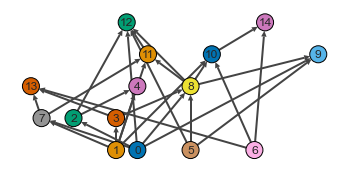

In [63]:
plot_precedencias(gerar_rcpsp(15, 15, 0.35))

Acompanhado deste grafo também podemos avaliar a solução armazenada na classe ```rcpsp``` através da função ```plot_gantt```.

In [64]:
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(style="white")
from matplotlib.ticker import MultipleLocator

def plot_gantt(rcpsp):
  fig, ax = plt.subplots()
  fig.set_size_inches(10,15)
  palette = sns.color_palette("colorblind", len(rcpsp.tarefas))
  
  rcpsp.tarefas.sort(key=lambda x : x.data)
  makespan = rcpsp.makespan()
  rc = [ [-1]* makespan for i in range(rcpsp.recursos)]

  for j in rcpsp.tarefas:
    t = j.data
    consumiu = 0
    for r in range(rcpsp.recursos):
      if rc[r][t] == -1:
        for d in range(j.duracao):
          rc[r][t+d] = j.id
        consumiu += 1
      if consumiu == j.consumo: break
  
  for t in range(makespan):
    for r in range(rcpsp.recursos):
      if (rc[r][t] >= 0):
        ax.add_patch(FancyBboxPatch((t, r), 1, 1,
                          boxstyle="round,pad=-0.01,rounding_size=0.10",
                          ec="none", fc=palette[rc[r][t]],
                          mutation_aspect=2 ) )

  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))
  plt.grid()
  plt.axis('scaled')
  ax.autoscale()
  

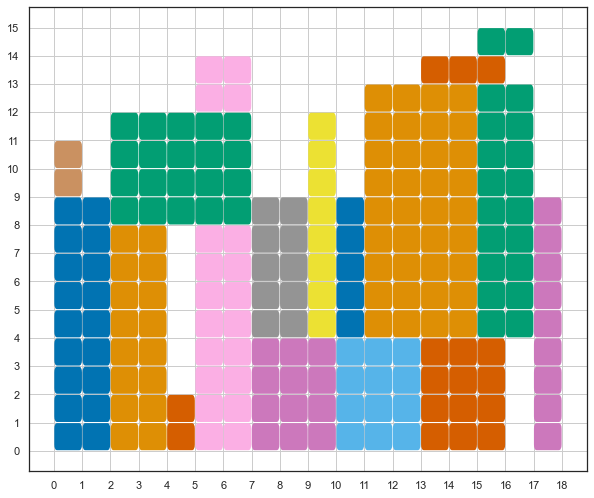

In [65]:
plot_gantt(esquema_construtivo(gerar_rcpsp(15, 15, 0.35)))

# Esquema serial para metaheurísticas

Observamos que o esquema serial apresentado anteriormente tem como tarefa a construção de uma *ordernação topológica* dos vértices. Sobre ela é feita iterativamente a *datagem* das tarefas.

Podemos fazer uma pequena adaptação neste algoritmo para que uma ordenação topológica seja previamente fornecida para o algoritmo de *datagem*. O objetivo desta modificação é que ela permite trabalharmos sobre as ordenações topológicas (que são objetos matemáticos mais simples).

Dessa forma as metaheurísticas iriam tão somente se concentrar em gerar ou modificar ordenações topológicas em seus operadores, facilitando a aplicação destas metodologias.

Definimos a seguir o algoritmo ```datagem```, uma adaptação do ```esquema_construtivo``` que recebe um parâmetro extra: a ordenação topológica das tarefas.

In [66]:
import copy

def datagem(rcpsp, ordenacao):
  """Percorre as tarefas na ordem especificada pela ordenação reproduzindo as]
  operações do algoritmo de esquema construtivo."""
  solucao = RCPSP()
  solucao.recursos = rcpsp.recursos
  data_mais_cedo = [0 for j in rcpsp.tarefas]
  restantes = copy.deepcopy(rcpsp.tarefas)
  pi = 0
  while restantes:
    j = rcpsp.tarefas[ordenacao[pi]]
    alocar_tarefa(j, solucao.tarefas, rcpsp.recursos, data_mais_cedo[j.id])
    restantes = [ x for x in restantes if x.id != j.id ]
    solucao.tarefas.append(copy.deepcopy(j))
    for k in restantes:
      if (j.id in k.dependencia):
        k.dependencia.remove(j.id)
        data_mais_cedo[k.id] = max(data_mais_cedo[k.id], j.data + j.duracao)
    pi = pi + 1
  return solucao

Lembramos que qualquer permutação pode ser uma ordenação topológica, desde que obedeça as precedências da instância. O código ```testa_topologica``` a seguir testa se uma ordenação passada obedece todas as devidas relações.

In [67]:
def testa_topologica(rcpsp, ordenacao):
  top = True
  for j in range(len(ordenacao)-1, 0, -1):
    for i in range(j):
      if (ordenacao[j] in rcpsp.tarefas[ordenacao[i]].dependencia):
        top = False
        break
    if top == False: break
  return top

## Método força bruta

Utilizando-se da possibilidade de gerar todas as permutações e testar cada uma delas quanto à adequação topológica, podemos desenhar um método que envia todas as permutações viáveis para o algoritmo de datagem afim de obter o menor valor de *makespan* possível.

In [68]:
def forca_bruta(rcpsp):
    """Gera todas as possíveis ordenções topológicas e data cada uma delas. 
       Então escolhe a menor delas."""
    return min([datagem(rcpsp, x) for x in ordenacoes_topologicas_eficientes(rcpsp) ], key=lambda x : x.makespan() )

todas_as_permutacoes = itertools.permutations
def ordenacoes_topologicas(rcpsp):
  return list(filter(lambda pi : testa_topologica(rcpsp, pi), todas_as_permutacoes(range(len(rcpsp.tarefas)))))

Evidentemente se todas as ordenações topológicas são em número inferior a todas as permutações então testar se todas as permutações são ordenações topológicas é muito ineficiente. 

Portanto vamos escrever uma função recursiva ```ot_recursiva``` para gerar todas as ordenações topológicas das precedências.

In [69]:
def ordenacoes_topologicas_eficientes(rcpsp):
    ordenacoes = []
    visitado = []
    grau = []
    for i in range(len(rcpsp.tarefas)):
      visitado.append(False)
      grau.append(len(rcpsp.tarefas[i].dependencia))
    ot_recursiva(rcpsp, ordenacoes, [], visitado, grau)
    return ordenacoes

def ot_recursiva(rcpsp, ordenacoes, ordem, visitado, grau):
  flag = False
  for i in range(len(rcpsp.tarefas)):
    if grau[i] == 0 and not visitado[i]:

      for j in range(i, len(rcpsp.tarefas)):
        if i in rcpsp.tarefas[j].dependencia:
          grau[j] -= 1      
      ordem.append(i)
      visitado[i] = True

      ot_recursiva(rcpsp, ordenacoes, ordem, visitado, grau)
            
      visitado[i] = False
      ordem.pop()
      for j in range(i, len(rcpsp.tarefas)):
        if i in rcpsp.tarefas[j].dependencia:
          grau[j] += 1
            
      flag = True
    
  # Chegamos aqui se todos os vértices forem visitados.
  if not flag:
    ordenacoes.append(ordem.copy())


Fonte: Geeks for Geeks. *All Topological Sorts of a Directed Acyclic Graph*. Acessível em: https://www.geeksforgeeks.org/all-topological-sorts-of-a-directed-acyclic-graph/.

Transformado em código Python por chatGPT. (OpenAI. *Introducing chatGPT*. Acessível em https://openai.com/blog/chatgpt)

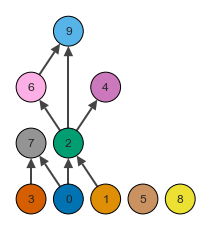

In [70]:
plot_precedencias(gerar_rcpsp(10, 5, 0.20, rseed=1))

In [71]:
otcontador = len(ordenacoes_topologicas_eficientes(gerar_rcpsp(10, 5, 0.20, rseed=1)))
print(otcontador, "ordenações topológicas ({0:0.2f}".format(100*otcontador/math.factorial(10)), "%)") 

14040 ordenações topológicas (0.39 %)


In [72]:
forca_bruta(gerar_rcpsp(10, 5, 0.20, rseed=1))

Tarefas = 10	Recursos = 5	Makespan = 17

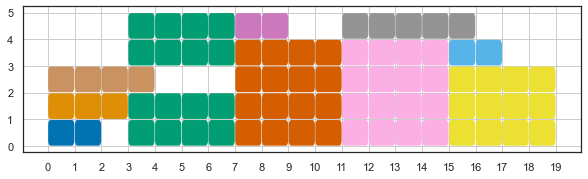

In [73]:
plot_gantt(datagem(gerar_rcpsp(10, 5, 0.2, rseed=1), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ))

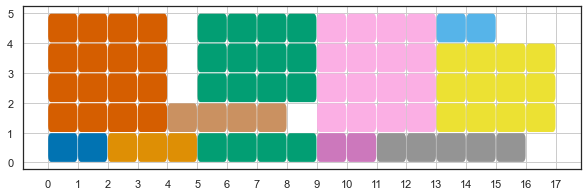

In [74]:
plot_gantt(forca_bruta(gerar_rcpsp(10, 5, 0.2, rseed=1)))

## Exercícios



1.   Crie um operador de modificar uma ordenação topológica para gerar uma nova ordenação topológica válida. 

2.   Utilize este operador criado no exercício anterior e o método ```datagem``` para criar uma metaheurística para para o RCPSP. Detalhe suas escolhas sobre o método elaborado.



## Resolução

### 1. Modificando as definições acima

In [75]:
from typing import List, Iterable, Tuple, Callable
from enum import Enum
from numpy import random

In [76]:
class RCPSP:
  def __init__(self, rng = None, seed = None):
    self.tarefas = []
    self.recursos = []
    if seed is not None: self.seed = seed
    self.rng = None if rng is None else random.default_rng(seed)

  def makespan(self) -> int:
    ultima = max( self.tarefas, key=lambda x : x.data + x.duracao)
    if (ultima.data >= 0): makespan = ultima.data+ultima.duracao
    else: makespan = -1
    return makespan
  
  @staticmethod
  def gerar_rcpsp(n: int, recursos: int, densidade: float = 0.2, rng = None, rseed: int = 233) -> RCPSP:
    if rng is None: rng = random.default_rng(233)
    rcpsp = RCPSP(rng, rseed)
    rcpsp.tarefas = [Tarefa(j, rng.integers(low=1,high=6), rng.integers(low=1,high=round(recursos*0.7))) for j in range(n) ]
    for j in range(n):
      for i in range(j):
        if rng.random() < densidade:
          rcpsp.tarefas[j].adicionar_dependencia(i)
    rcpsp.recursos = recursos
    return rcpsp

  def __repr__(self):
    return f"Tarefas = {len(self.tarefas)}\tRecursos = {self.recursos}\tMakespan = {self.makespan()}"
  def __str__(self):
    return f"Tarefas = {len(self.tarefas)}\tRecursos = {self.recursos}\tMakespan = {self.makespan()}"

In [77]:
def plot_precedencias(g: ig.Graph, ax: plt.Axes = None, title: str = None, **kwargs) -> None:
  if ax == None:
    fig, ax = plt.subplots()
    fig.set_size_inches(13,20)
    
  numero_de_tarefas = len(g.vs)
  indices_das_tarefas = g.vs.indices
  palette = sns.color_palette("colorblind", numero_de_tarefas)

  g.vs["label"] = indices_das_tarefas
  g.vs["color"] = [palette[x] for x in indices_das_tarefas ]
  if title is not None: ax.set_title(title)
  ig.plot(g,  target=ax,
              bbox=(900, 600),
              vertex_size=0.5, 
              edge_arrow_size=0.02,
              layout=g.layout(**kwargs)
              )

In [78]:
class Relacao(Enum):
    Predecessores = "Precedência"
    Sucessores = "Sucedência"

def criarGrafo(rcpsp: RCPSP, direcionado: bool = True, relacao: Relacao = Relacao.Sucessores) -> ig.Graph:
    g = ig.Graph(directed=direcionado)
    g.add_vertices(len(rcpsp.tarefas))
    for j in rcpsp.tarefas:
        for i in rcpsp.tarefas[j.id].dependencia:
            if relacao == Relacao.Sucessores:
                g.add_edge(i, j.id)
            else:
                g.add_edge(j.id, i)
    return g

In [79]:
def gera_grafo_de_ordernacoes_validas(g: ig.Graph) -> ig.Graph:
    res = ig.Graph()
    res.add_vertices(g.vs.indices)
    precedencias = []
    for v in g.vs:
        precedencias.append(set())
        busca_em_profundidade = g.dfsiter(v)
        for precedente in busca_em_profundidade: 
            precedencias[-1].add(precedente.index)
    for i, v in enumerate(g.vs.indices):
        for j, u in enumerate(g.vs.indices[i + 1:], i + 1):
            if j not in precedencias[i] and i not in precedencias[j]:
                res.add_edge(u, v)
    return res

In [80]:
def plot_grafos(gs: List[ig.Graph], titles: List[str] = None, **kwargs) -> None:
  fig, axes = plt.subplots(1, len(gs))
  fig.set_size_inches(13, 20)
  title = iter(titles) if titles is not None else None
  layout = iter(kwargs['layout']) if 'layout' in kwargs else None
  vgap = iter(kwargs['vgap']) if 'vgap' in kwargs else None
  for g, axis in zip(gs, axes):
    kwargs = {}
    try:
      if layout: kwargs['layout'] = next(layout)
    except StopIteration:
      pass
    try:
      if vgap: kwargs['vgap'] = next(vgap)
    except StopIteration:
      pass
    plot_precedencias(g, axis, next(title) if title is not None else title, **kwargs)

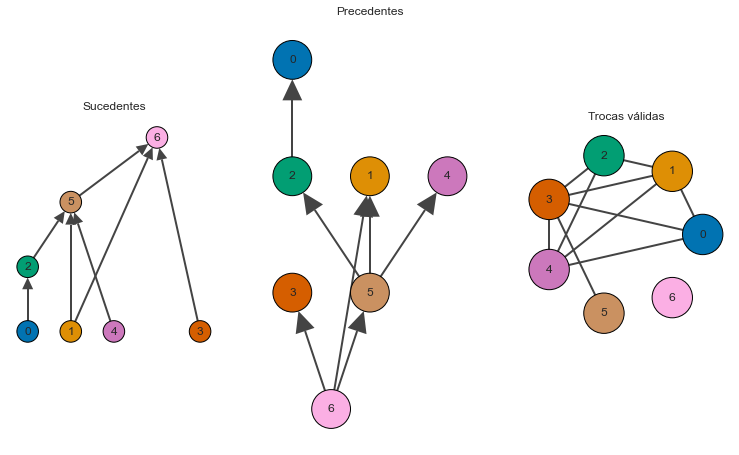

In [81]:
rcpsp = RCPSP.gerar_rcpsp(7, 15, 0.35)
g_sucess = criarGrafo(rcpsp)
g2_pred = criarGrafo(rcpsp, True, Relacao.Predecessores)
g_ord = gera_grafo_de_ordernacoes_validas(g2_pred)
plot_grafos([g_sucess, g2_pred, g_ord], ['Sucedentes', 'Precedentes', 'Trocas válidas'],
            layout=['sugiyama', 'sugiyama', 'circle'], vgap=[1.5, 1.5])

In [82]:
def conjunto_das_partes(lst: List, escolhe: Iterable = None) -> itertools.chain[Tuple]:
    if escolhe is None: escolhe = range(len(lst) + 1)
    return itertools.chain.from_iterable(itertools.combinations(lst, r) for r in escolhe)

In [83]:
def modificar_ordernacao_topologica(ordernacao_topologica: List[int], rcpsp: RCPSP, rng, quantidade: int = None, distancias: int = [1]) -> List[List[int]]:
    g = criarGrafo(rcpsp, direcionado=True, relacao=Relacao.Predecessores)
    g_ord = gera_grafo_de_ordernacoes_validas(g)
    trocas_validas = g_ord.get_edgelist()
    sequencias_de_trocas_validas = conjunto_das_partes(trocas_validas, escolhe=distancias)
    if quantidade is not None:
        sequencias_de_trocas_validas = rng.choice(list(sequencias_de_trocas_validas), size=quantidade, replace=False)    
    novas_ordenacoes = []
    for sequencia in sequencias_de_trocas_validas:
        nova_orden = ordernacao_topologica.copy()
        for i, j in sequencia:
            nova_orden[i], nova_orden[j] = nova_orden[j], nova_orden[i]
        novas_ordenacoes.append(nova_orden)
    return novas_ordenacoes

In [84]:
def valorar_solucao(x): return datagem(rcpsp, x).makespan()
rng = random.default_rng(223)
def gerar_vizinhanca(x): return modificar_ordernacao_topologica(x, rcpsp, rng, quantidade=10)
def validar_solucao(x): return testa_topologica(rcpsp, x)

In [85]:
def busca_tabu(solucao_inicial, valorar_solucao, gerar_vizinhanca, validar_solucao,
                  tamanho_da_lista_tabu=10, max_iteracoes=1000):
    solucao_atual = solucao_inicial
    melhor = solucao_atual
    lista_tabu = [solucao_atual]
    numero_de_iteracoes_sem_melhoria = 0

    for _ in range(max_iteracoes):
        solucoes_candidatas = gerar_vizinhanca(solucao_atual)

        for solucao_candidata in solucoes_candidatas:
            if solucao_candidata not in lista_tabu and validar_solucao(solucao_candidata):
                if valorar_solucao(solucao_candidata) < valorar_solucao(solucao_atual):
                    solucao_atual = solucao_candidata
                    numero_de_iteracoes_sem_melhoria = 0

                    if valorar_solucao(solucao_atual) < valorar_solucao(melhor):
                        melhor = solucao_atual

                lista_tabu.append(solucao_candidata)
                if len(lista_tabu) > tamanho_da_lista_tabu:
                    lista_tabu.pop(0)

        numero_de_iteracoes_sem_melhoria += 1
        if numero_de_iteracoes_sem_melhoria >= tamanho_da_lista_tabu:
            lista_tabu.clear()
            lista_tabu.append(solucao_atual)
            numero_de_iteracoes_sem_melhoria = 0

    return melhor

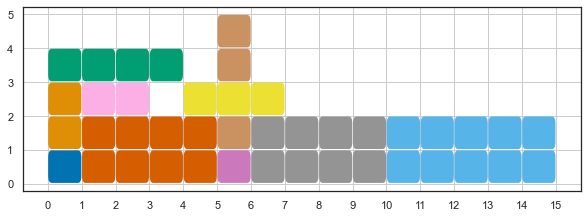

In [86]:
rcpsp = RCPSP.gerar_rcpsp(10, 5, 0.20, rseed = 1)
plot_gantt(datagem(rcpsp, list(range(10))))

In [87]:
ordenacao_inicial = list(range(10))
res = busca_tabu(ordenacao_inicial, valorar_solucao, gerar_vizinhanca, validar_solucao)
print(res)

[0, 1, 7, 3, 4, 5, 6, 2, 8, 9]


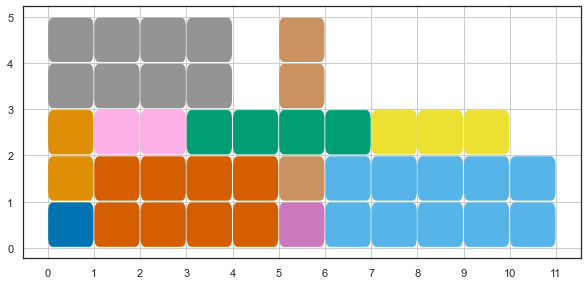

In [88]:
plot_gantt(rcpsp)